In [4]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import json
import os
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis

In [7]:
df = pd.read_csv("../data/processed/transformed_data.csv")

In [25]:
df.head()

,gameDuration,championId,teamId,individualPosition,kills,deaths,assists,win,goldEarned,totalDamageDealt,...,Legendary_1_id,Legendary_1_purchase_time,Legendary_2_id,Legendary_2_purchase_time,Keystone,PrimarySlot1,PrimarySlot2,PrimarySlot3,SecondarySlot1,SecondarySlot2
0,2203,516,100,0,5,6,12,0,14278,39863,...,3068,819,6665,1262,8437,8446,8473,8451,8009,9105
1,2203,254,100,1,12,9,12,0,14699,40145,...,3078,740,6610,1122,8010,9111,9104,8014,8304,8347
2,2203,202,100,3,5,10,16,0,13550,38251,...,3031,893,3094,1309,8021,8009,9103,8017,8304,8347
3,2203,134,100,2,11,8,14,0,17384,54600,...,6655,505,4628,1082,8369,8321,8313,8347,8210,8236
4,2203,40,100,4,1,5,22,0,9047,9208,...,3222,1074,6620,1590,8214,8226,8234,8232,8136,8105


In [17]:
# creating randomized subset
subset_df = df.sample(frac=0.1, random_state=42)

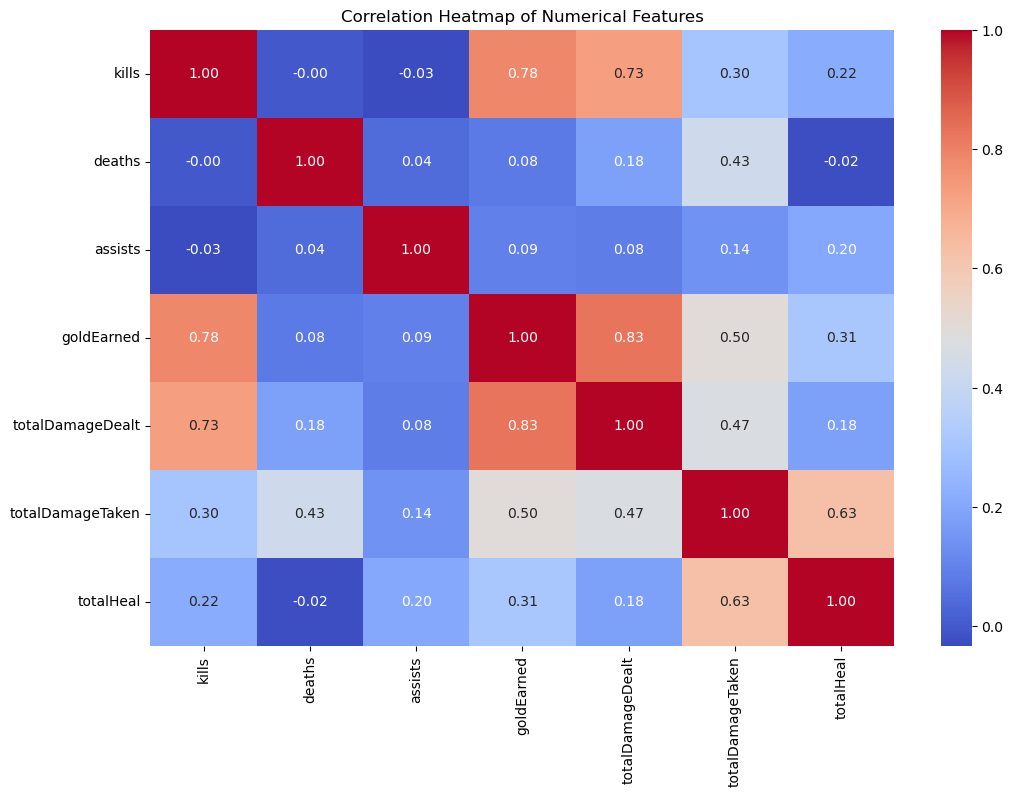

In [27]:
# correlation heatmap of numerical features
plt.figure(figsize=(12, 8))
corr = subset_df[['kills', 'deaths', 'assists', 'goldEarned', 'totalDamageDealt', 'totalDamageTaken', 'totalHeal']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

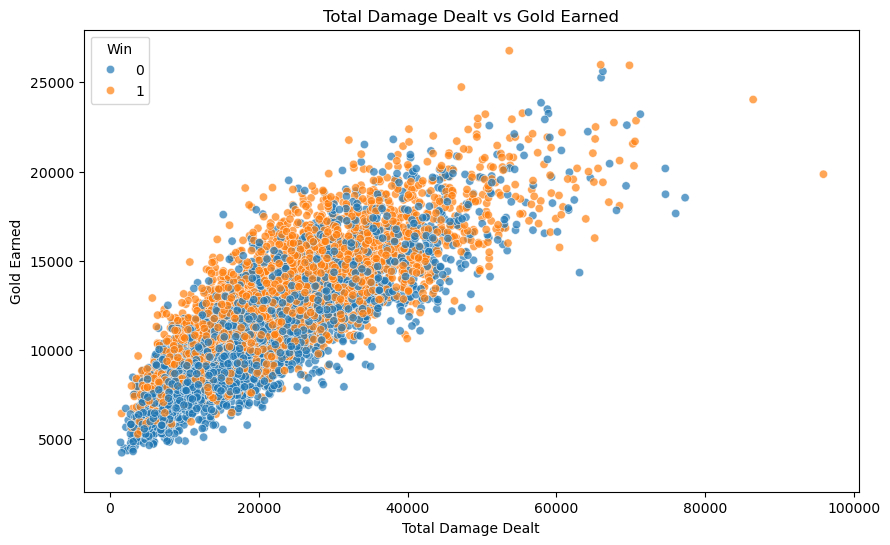

In [29]:
# scatter plot of total damage dealt vs gold earned
plt.figure(figsize=(10, 6))
sns.scatterplot(x=subset_df['totalDamageDealt'], y=subset_df['goldEarned'], hue=subset_df['win'], alpha=0.7)
plt.title('Total Damage Dealt vs Gold Earned')
plt.xlabel('Total Damage Dealt')
plt.ylabel('Gold Earned')
plt.legend(title='Win', loc='upper left')
plt.show()

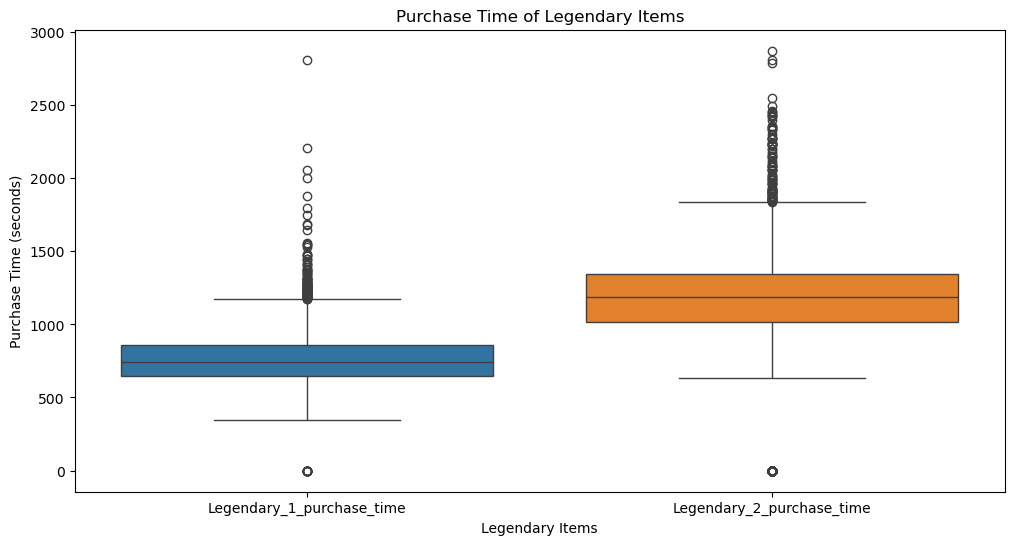

In [31]:
# purchase time of Legendary items
plt.figure(figsize=(12, 6))
sns.boxplot(data=subset_df[['Legendary_1_purchase_time', 'Legendary_2_purchase_time']])
plt.title('Purchase Time of Legendary Items')
plt.xlabel('Legendary Items')
plt.ylabel('Purchase Time (seconds)')
plt.show()

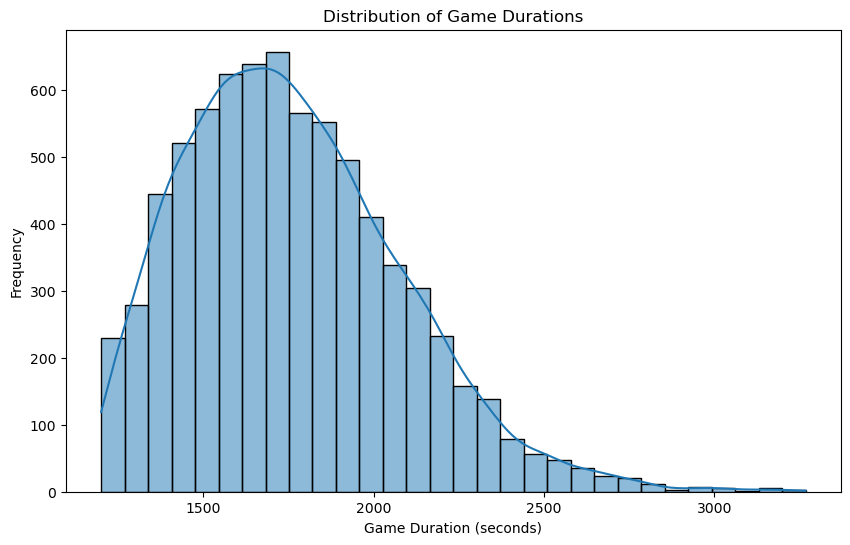

In [33]:
# distribution of game durations
plt.figure(figsize=(10, 6))
sns.histplot(subset_df['gameDuration'], bins=30, kde=True)
plt.title('Distribution of Game Durations')
plt.xlabel('Game Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

## Pipeline / Basic Modeling

In [13]:
# load DataFrame
df = df.copy()

# define input features and target features
input_features = [
    "championId", "matchupChampion", "individualPosition", 
    "kills", "deaths", "assists", 
    "goldEarned", "totalDamageDealt", 
    "totalDamageTaken", "totalHeal", "win"
]
target_features = [
    "Boots_id", "Legendary_1_id", "Legendary_2_id",
    "Keystone", "PrimarySlot1", "PrimarySlot2",
    "PrimarySlot3", "SecondarySlot1", "SecondarySlot2"
]

# one-hot encode individualPosition
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')

# scale numerical features
scaler = StandardScaler()

# preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("position", one_hot_encoder, ["individualPosition"]),
        ("scaling", scaler, ["kills", "deaths", "assists", "goldEarned", "totalDamageDealt", "totalDamageTaken", "totalHeal"])
    ],
    remainder='passthrough'  # keep championId, matchupChampion, win as-is
)

# function to apply label encoding to the target features
def encode_target(y, label_encoders=None):
    # if y is a NumPy array, convert it to DataFrame
    if isinstance(y, np.ndarray):
        y = pd.DataFrame(y, columns=target_features)

    encoded_y = pd.DataFrame()
    if label_encoders is None:
        label_encoders = {}
    for col in y.columns:
        if col not in label_encoders:
            le = LabelEncoder()
            encoded_y[col] = le.fit_transform(y[col])
            label_encoders[col] = le
        else:
            encoded_y[col] = label_encoders[col].transform(y[col])
    return encoded_y, label_encoders

# encoding target features using FunctionTransformer
def target_transform(y):
    global label_encoders
    encoded_y, label_encoders = encode_target(y, label_encoders=None)
    return encoded_y

# initialize label encoders
label_encoders = {}

# create pipeline for the entire data processing
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("label_encoder", FunctionTransformer(target_transform, validate=False))
])

# fit and transform the input features
X = df[input_features]
y = df[target_features]
pipeline.fit_transform(X)

ValueError: Shape of passed values is (74550, 15), indices imply (74550, 9)

In [15]:
pipeline_path = "../models/preprocessing_pipeline.pkl"

# save the pipeline to a file
joblib.dump(pipeline, pipeline_path)

['../models/preprocessing_pipeline.pkl']

In [43]:
# fit and transform the input features
X = df[input_features]
X_processed = pipeline.fit_transform(X)

# target features (outputs)
y = df[target_features]

In [19]:
# initialize the base classifier
base_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
multi_target_classifier = MultiOutputClassifier(base_classifier)

# fit the classifier
multi_target_classifier.fit(X_processed, y)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42))

In [31]:
# load champion, item, and rune datasets
with open("../data/raw/champion_data/champions.json", "r") as f:
    champion_data = json.load(f)["data"]

with open("../data/raw/item_data/items.json", "r") as f:
    item_data = json.load(f)["data"]

with open("../data/raw/runes_data/runes.json", "r") as f:
    rune_data = json.load(f)

# create lookup dictionaries
champion_name_to_id = {v["name"].lower(): int(v["key"]) for k, v in champion_data.items()}
champion_id_to_name = {int(v["key"]): v["name"] for k, v in champion_data.items()}

item_id_to_name = {int(k): v["name"] for k, v in item_data.items()}

# extract rune IDs and names properly from runes data
rune_id_to_name = {}
for style in rune_data:
    # add the main style name
    rune_id_to_name[style["id"]] = style["name"]

    # add individual runes within each style
    for slot in style["slots"]:
        for rune in slot["runes"]:
            rune_id_to_name[rune["id"]] = rune["name"]

In [49]:
def predict_optimal_build(champion_name, matchup_champion_name, df, pipeline, model):
    """
    Predict the optimal item build and runes for the given champion and matchup champion.
    
    Parameters:
    - champion_name: str, champion name of the player.
    - matchup_champion_name: str, champion name of the opponent.
    - df: DataFrame, original DataFrame with historical data.
    - pipeline: preprocessing pipeline used for transforming the features.
    - model: trained MultiOutputClassifier model.

    Returns:
    - DataFrame, containing the predicted items and runes.
    """
    # convert champion names to IDs
    champion_id = champion_name_to_id.get(champion_name.lower())
    matchup_champion_id = champion_name_to_id.get(matchup_champion_name.lower())

    if champion_id is None or matchup_champion_id is None:
        raise ValueError(f"Champion name(s) provided are not valid: {champion_name}, {matchup_champion_name}")

    # create a new input DataFrame with average values for other features
    input_data = df[(df['championId'] == champion_id) & (df['matchupChampion'] == matchup_champion_id)].mean().to_dict()

    # override champion-specific fields
    input_data['championId'] = champion_id
    input_data['matchupChampion'] = matchup_champion_id

    # create a DataFrame for input
    input_features = df.columns.difference(target_features)
    input_df = pd.DataFrame([input_data], columns=input_features)

    # preprocess the input features using the pipeline
    input_processed = pipeline.transform(input_df)

    # predict the output
    predicted_output = model.predict(input_processed)

    # convert the prediction to a DataFrame for better readability
    predicted_df = pd.DataFrame(predicted_output, columns=target_features)

    # convert IDs to item and rune names for user-friendly output
    for col in ['Boots_id', 'Legendary_1_id', 'Legendary_2_id']:
        predicted_df[col] = predicted_df[col].apply(lambda x: item_id_to_name.get(int(x), "Unknown Item"))

    for col in ['Keystone', 'PrimarySlot1', 'PrimarySlot2', 'PrimarySlot3', 'SecondarySlot1', 'SecondarySlot2']:
        predicted_df[col] = predicted_df[col].apply(lambda x: rune_id_to_name.get(int(x), "Unknown Rune"))

    return predicted_df

# example usage
champion_name = "Ambessa"  
matchup_champion_name = "Aatrox"  

#prediction function
predicted_build = predict_optimal_build(champion_name, matchup_champion_name, df, pipeline, multi_target_classifier)

# print results
print(f"Suggested Items and Runes for the given matchup: {champion_name} vs {matchup_champion_name}")
print(predicted_build)

Suggested Items and Runes for the given matchup: Ambessa vs Aatrox
       Boots_id Legendary_1_id Legendary_2_id   Keystone PrimarySlot1  \
0  Unknown Item        Eclipse  Black Cleaver  Conqueror      Triumph   

       PrimarySlot2 PrimarySlot3 SecondarySlot1 SecondarySlot2  
0  Legend: Alacrity   Last Stand    Second Wind     Overgrowth  
